In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
english_stopwords = [stemmer.stem(stopword) for stopword in stopwords.words("english")]

from utils import plot_confusion_matrix, preprocess_word, EmotionDataset

## Helper functions and preprocessing

In [74]:
emotion_dataset = EmotionDataset()

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/nikit/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [75]:
dataset = emotion_dataset.dataset
LABEL_TO_EMOTION_DICT = emotion_dataset.LABEL_TO_EMOTION_DICT
SEED = 42

In [76]:
train_texts_l = dataset["train"]["text"]
train_labels_l = dataset["train"]["label"]

ros = RandomOverSampler(random_state=SEED)
train_texts_resampled, train_labels_resampled = ros.fit_resample(np.array(train_texts_l).reshape(-1, 1), train_labels_l)
train_texts_resampled = train_texts_resampled.reshape(-1)

val_texts_l = dataset["validation"]["text"]
val_labels_l = dataset["validation"]["label"]

Text(0.5, 1.0, 'Class frequences in training set')

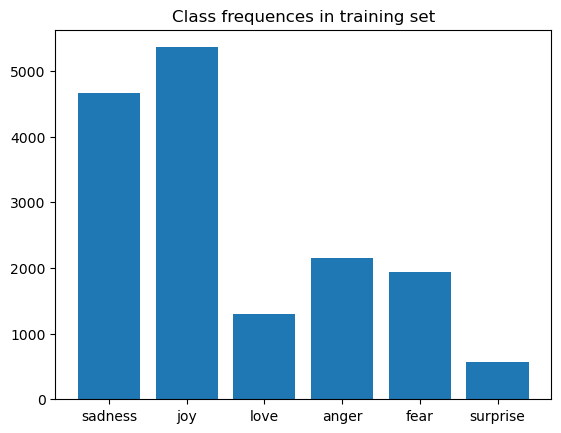

In [77]:
plt.bar(LABEL_TO_EMOTION_DICT.values(), np.unique(train_labels_l, return_counts=True)[1])
plt.title("Class frequences in training set")

Text(0.5, 1.0, 'Class frequences in training set (oversampled)')

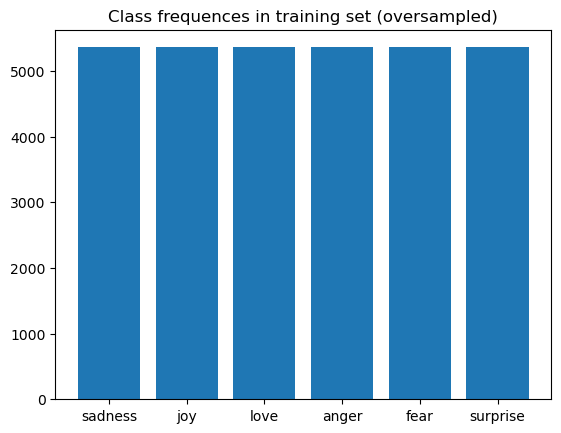

In [78]:
plt.bar(LABEL_TO_EMOTION_DICT.values(), np.unique(train_labels_resampled, return_counts=True)[1])
plt.title("Class frequences in training set (oversampled)")

In [79]:
count_vectorizer = CountVectorizer(tokenizer=word_tokenize, preprocessor=preprocess_word, stop_words=english_stopwords)
tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize, preprocessor=preprocess_word, stop_words=english_stopwords)

In [80]:
count_matrix = count_vectorizer.fit_transform(train_texts_l)

word_features = count_vectorizer.get_feature_names_out()
counts = count_matrix.toarray().sum(axis=0)

word_counts_df = pd.DataFrame()
word_counts_df.loc[:, "word"] = word_features
word_counts_df.loc[:, "count"] = counts
word_counts_df.sort_values("count", ascending=False)

c:\programs\x64\conda\envs\ml_stuff\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", "'d", "'ll", 'becau', 'could', 'does', 'has', 'might', 'must', "n't", 'need', 'r', 'sha', 'v', 'was', 'wo', 'would'] not in stop_words.
  warnings.warn(


,word,count
5204,feel,11231
5208,feeling,5083
8144,like,2899
6895,im,2430
15382,was,2210
...,...,...
9320,nearing,1
3146,craps,1
9322,nearness,1
3142,cranny,1


## Naive Bayes

In [81]:
count_pipeline = Pipeline([
    ("vectorizer", count_vectorizer),
    ("classifier", MultinomialNB())
])

In [82]:
count_pipeline.fit(train_texts_l, train_labels_l)
pass

### Counts as features

In [83]:
print("Count_pipeline without resampling:")

print("Train accuracy:", count_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", count_pipeline.score(val_texts_l, val_labels_l))

Count_pipeline without resampling:
Train accuracy: 0.89075
Validation accuracy: 0.7625


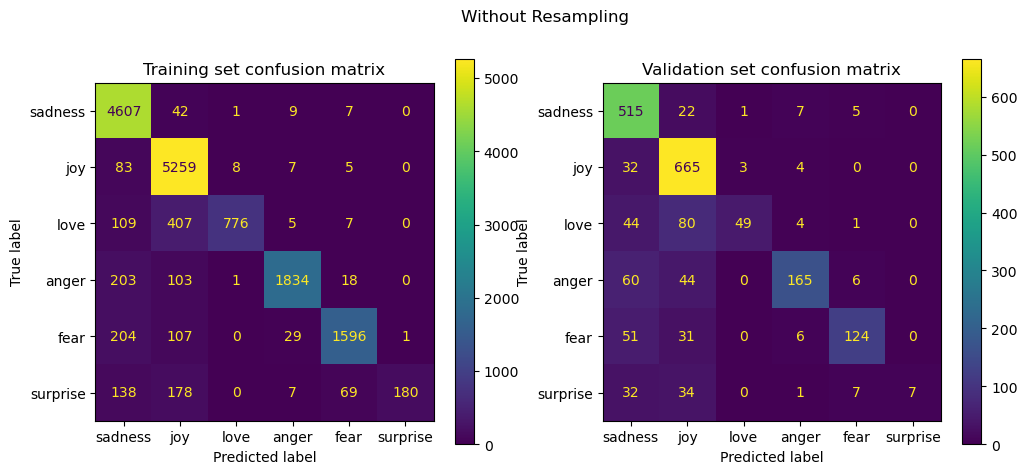

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Without Resampling")
plot_confusion_matrix(train_labels_l, count_pipeline.predict(train_texts_l), LABEL_TO_EMOTION_DICT.values(), ax=axs[0])
axs[0].set_title("Training set confusion matrix")
plot_confusion_matrix(val_labels_l, count_pipeline.predict(val_texts_l), LABEL_TO_EMOTION_DICT.values(), ax=axs[1])
axs[1].set_title("Validation set confusion matrix")
plt.show()

In [85]:
count_pipeline.fit(train_texts_resampled, train_labels_resampled)
pass

In [86]:
print("Count_pipeline with resampling:")

print("Train accuracy:", count_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", count_pipeline.score(val_texts_l, val_labels_l))

Count_pipeline with resampling:
Train accuracy: 0.935625
Validation accuracy: 0.792


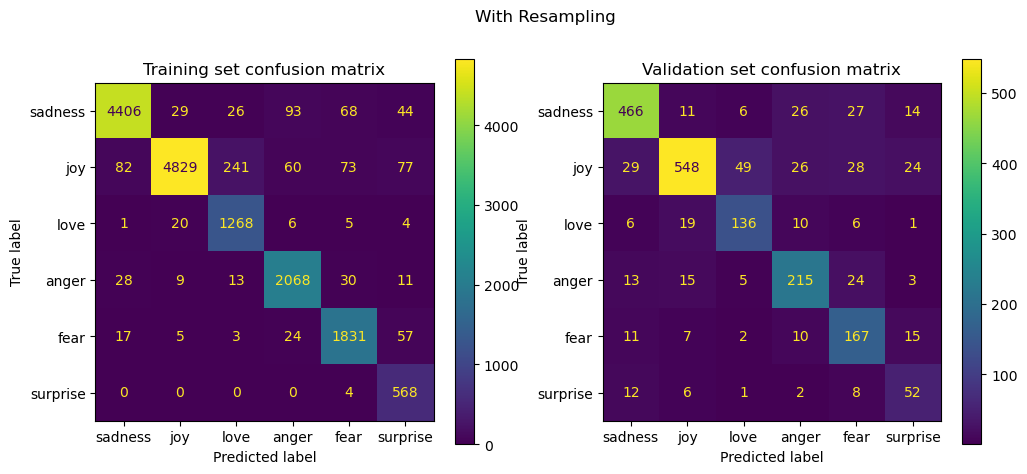

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("With Resampling")
plot_confusion_matrix(train_labels_l, count_pipeline.predict(train_texts_l), LABEL_TO_EMOTION_DICT.values(), ax=axs[0])
axs[0].set_title("Training set confusion matrix")
plot_confusion_matrix(val_labels_l, count_pipeline.predict(val_texts_l), LABEL_TO_EMOTION_DICT.values(), ax=axs[1])
axs[1].set_title("Validation set confusion matrix")
plt.show()

### TFIDF as features

In [88]:
tfidf_pipeline = Pipeline([
    ("vectorizer", tfidf_vectorizer),
    ("classifier", MultinomialNB())
])

In [89]:
tfidf_pipeline.fit(train_texts_l, train_labels_l)

c:\programs\x64\conda\envs\ml_stuff\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", "'d", "'ll", 'becau', 'could', 'does', 'has', 'might', 'must', "n't", 'need', 'r', 'sha', 'v', 'was', 'wo', 'would'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(preprocessor=<function preprocess_word at 0x0000022C69BC6700>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'hi', 'himself', 'she',
                                             "she'", 'her', 'her', 'herself',
                                             'it', "it'", 'it', 'itself', ...],
                                 tokenizer=<function word_tokenize at 0x0000022C54017AF0>)),
                ('classifier', MultinomialNB())])

In [90]:
print("Tfidf_pipeline without resampling:")

print("Train accuracy:", tfidf_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", tfidf_pipeline.score(val_texts_l, val_labels_l))

Tfidf_pipeline without resampling:
Train accuracy: 0.7273125
Validation accuracy: 0.659


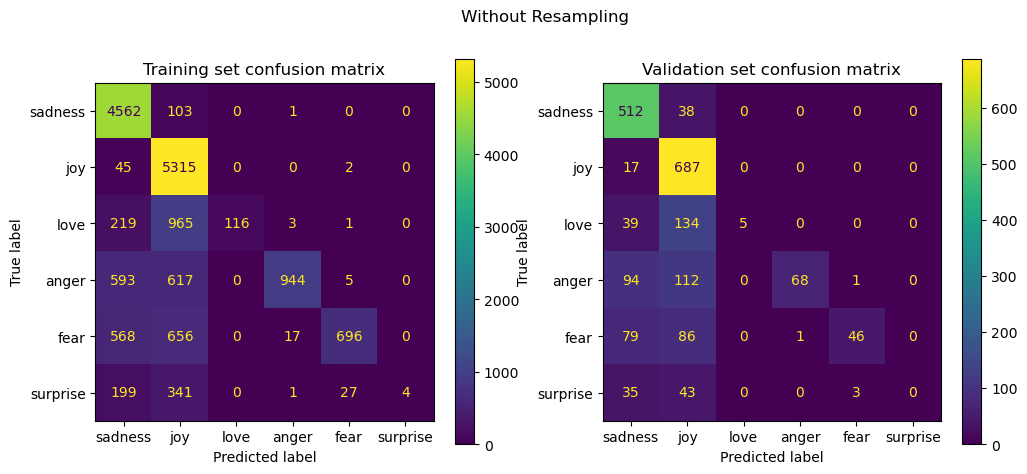

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(train_labels_l, tfidf_pipeline.predict(train_texts_l), LABEL_TO_EMOTION_DICT.values(), ax=axs[0])
axs[0].set_title("Training set confusion matrix")
plot_confusion_matrix(val_labels_l, tfidf_pipeline.predict(val_texts_l), LABEL_TO_EMOTION_DICT.values(), ax=axs[1])
axs[1].set_title("Validation set confusion matrix")
fig.suptitle("Without Resampling")
plt.show()

In [92]:
tfidf_pipeline.fit(train_texts_resampled, train_labels_resampled)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(preprocessor=<function preprocess_word at 0x0000022C69BC6700>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'hi', 'himself', 'she',
                                             "she'", 'her', 'her', 'herself',
                                             'it', "it'", 'it', 'itself', ...],
                                 tokenizer=<function word_tokenize at 0x0000022C54017AF0>)),
                ('classifier', MultinomialNB())])

In [93]:
print("Tfidf_pipeline with resampling:")

print("Train accuracy:", tfidf_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", tfidf_pipeline.score(val_texts_l, val_labels_l))

Tfidf_pipeline with resampling:
Train accuracy: 0.9325625
Validation accuracy: 0.803


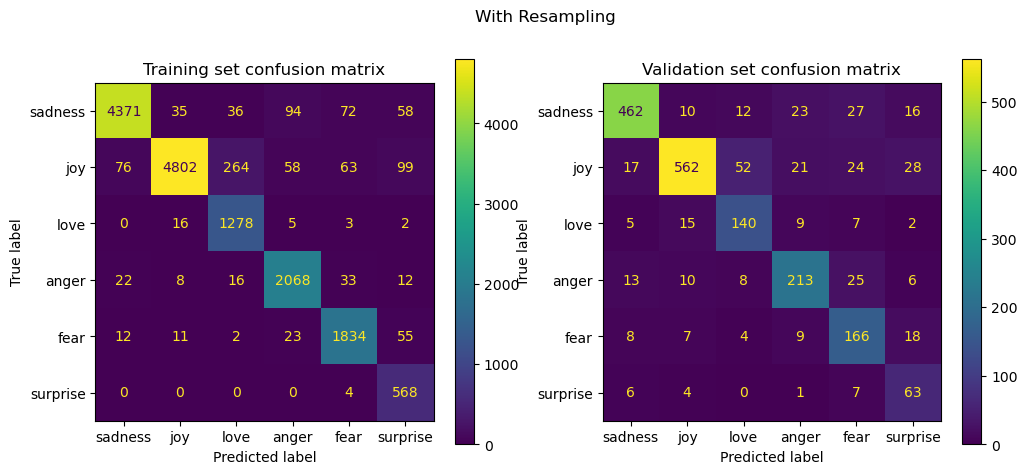

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(train_labels_l, tfidf_pipeline.predict(train_texts_l), LABEL_TO_EMOTION_DICT.values(), ax=axs[0])
axs[0].set_title("Training set confusion matrix")
plot_confusion_matrix(val_labels_l, tfidf_pipeline.predict(val_texts_l), LABEL_TO_EMOTION_DICT.values(), ax=axs[1])
axs[1].set_title("Validation set confusion matrix")
fig.suptitle("With Resampling")
plt.show()

## Simple Decision Tree

In [95]:
decisiontree_pipeline = Pipeline([
    ("vectorizer", count_vectorizer),
    ("classifier", DecisionTreeClassifier())
])

In [96]:
decisiontree_pipeline.fit(train_texts_l, train_labels_l)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(preprocessor=<function preprocess_word at 0x0000022C69BC6700>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'hi', 'himself', 'she',
                                             "she'", 'her', 'her', 'herself',
                                             'it', "it'", 'it', 'itself', ...],
                                 tokenizer=<function word_tokenize at 0x0000022C54017AF0>)),
                ('classifier', DecisionTreeClassifier())])

In [97]:
print("Decision Tree pipeline without resampling:")

print("Train accuracy:", decisiontree_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", decisiontree_pipeline.score(val_texts_l, val_labels_l))

Decision Tree pipeline without resampling:
Train accuracy: 0.9978125
Validation accuracy: 0.844


In [98]:
decisiontree_pipeline.fit(train_texts_resampled, train_labels_resampled)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(preprocessor=<function preprocess_word at 0x0000022C69BC6700>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'hi', 'himself', 'she',
                                             "she'", 'her', 'her', 'herself',
                                             'it', "it'", 'it', 'itself', ...],
                                 tokenizer=<function word_tokenize at 0x0000022C54017AF0>)),
                ('classifier', DecisionTreeClassifier())])

In [99]:
print("Decision Tree pipeline with resampling:")

print("Train accuracy:", decisiontree_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", decisiontree_pipeline.score(val_texts_l, val_labels_l))

Decision Tree pipeline with resampling:
Train accuracy: 0.9978125
Validation accuracy: 0.834


## Gradient Boosted Trees

In [100]:
gb_pipeline = Pipeline([
    ("vectorizer", count_vectorizer),
    ("classifier", GradientBoostingClassifier())
])

In [101]:
gb_pipeline.fit(train_texts_l, train_labels_l)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(preprocessor=<function preprocess_word at 0x0000022C69BC6700>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'hi', 'himself', 'she',
                                             "she'", 'her', 'her', 'herself',
                                             'it', "it'", 'it', 'itself', ...],
                                 tokenizer=<function word_tokenize at 0x0000022C54017AF0>)),
                ('classifier', GradientBoostingClassifier())])

In [102]:
print("Gradient Boosting pipeline without resampling:")

print("Train accuracy:", decisiontree_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", decisiontree_pipeline.score(val_texts_l, val_labels_l))

Gradient Boosting pipeline without resampling:
Train accuracy: 0.9978125
Validation accuracy: 0.834


In [103]:
gb_pipeline.fit(train_texts_resampled, train_labels_resampled)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(preprocessor=<function preprocess_word at 0x0000022C69BC6700>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'hi', 'himself', 'she',
                                             "she'", 'her', 'her', 'herself',
                                             'it', "it'", 'it', 'itself', ...],
                                 tokenizer=<function word_tokenize at 0x0000022C54017AF0>)),
                ('classifier', GradientBoostingClassifier())])

In [104]:
print("Gradient Boosting pipeline with resampling:")

print("Train accuracy:", decisiontree_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", decisiontree_pipeline.score(val_texts_l, val_labels_l))

Gradient Boosting pipeline with resampling:
Train accuracy: 0.9978125
Validation accuracy: 0.834


## Using pretrained Spacy embeddings

In [105]:
import spacy

In [106]:
nlp = spacy.load("en_core_web_sm")

In [107]:
class SpacyPreprocessor:
    def __init__(self, pipeline):
        self.pipeline = pipeline
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        result = []
        for sentence in X:
            result.append(self.pipeline(doc).vector)

        result = np.array(result)
        return result

In [108]:
spacy_pipeline = Pipeline([
    ('vectorizer', SpacyPreprocessor(nlp)),
    ('classifier', LogisticRegression())
])

In [109]:
spacy_pipeline.fit(train_texts_l, train_labels_l)

Pipeline(steps=[('vectorizer',
                 <__main__.SpacyPreprocessor object at 0x0000022C6D3602E0>),
                ('classifier', LogisticRegression())])

In [110]:
print("Logistic Regression on SpaCy embeddings without resampling:")

print("Train accuracy:", spacy_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", spacy_pipeline.score(val_texts_l, val_labels_l))

Logistic Regression on SpaCy embeddings without resampling:
Train accuracy: 0.335125
Validation accuracy: 0.352


In [111]:
spacy_pipeline = Pipeline([
    ('vectorizer', SpacyPreprocessor(nlp)),
    ('classifier', DecisionTreeClassifier())
])

In [112]:
spacy_pipeline.fit(train_texts_l, train_labels_l)

Pipeline(steps=[('vectorizer',
                 <__main__.SpacyPreprocessor object at 0x0000022C6A7457C0>),
                ('classifier', DecisionTreeClassifier())])

In [113]:
print("DecisionTreeClassifier on SpaCy embeddings without resampling:")

print("Train accuracy:", spacy_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", spacy_pipeline.score(val_texts_l, val_labels_l))

DecisionTreeClassifier on SpaCy embeddings without resampling:
Train accuracy: 0.335125
Validation accuracy: 0.352
